# Jigsaw Unintended Bias in Toxicity Classification, EDA + DL (Keras LSTM)

## Detect toxicity across a diverse range of conversations

In this competition, People were challenged to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. I will be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Details and the data of the competition can be found at [Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification)

In [1]:
!pip install -q kaggle



In [2]:
import os
from google.colab import files

def setup_kaggle():
    # Install Kaggle API
    !pip install kaggle

    # Upload kaggle.json file containing your API credentials
    print("Upload your kaggle.json file")
    files.upload()

    # Move kaggle.json to the correct location
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/

    # Set proper file permissions
    !chmod 600 ~/.kaggle/kaggle.json

def download_kaggle_competition_data(competition: str, output_dir: str = 'kaggle_competition_data'):
    # Check if Kaggle is set up, then download the competition dataset
    if not os.path.exists('~/.kaggle/kaggle.json'):
        setup_kaggle()

    # Create output directory if not exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Download the dataset
    !kaggle competitions download -c {competition} -p {output_dir}

    # Unzip all files in the output directory
    !unzip {output_dir}/*.zip -d {output_dir}

    # Delete the ZIP files after extraction
    !rm {output_dir}/*.zip

    print(f"Dataset downloaded, extracted, and ZIP files deleted from {output_dir}")



In [3]:
download_kaggle_competition_data('jigsaw-unintended-bias-in-toxicity-classification','input/jigsaw-unintended-bias-in-toxicity-classification')


Upload your kaggle.json file


Saving kaggle.json to kaggle.json
100% 721M/723M [00:10<00:00, 124MB/s]
100% 723M/723M [00:10<00:00, 71.1MB/s]
Archive:  input/jigsaw-unintended-bias-in-toxicity-classification/jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/test.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv  
  inflating: input/jigsaw-unintended-bias-in-toxicity-classification/train.csv  
Dataset downloaded, extr

## download and store embeddings in the local directory.

In [4]:
import os
import requests
import zipfile
import shutil

# Define the directories and URLs
embedding_dir1 = "input/fasttext-crawl-300d-2m/"
# embedding_dir2 = "input/glove840b300dtxt/"

fasttext_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
# glove_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"

# Function to clear the directory if it exists
def clear_directory(directory):
    if os.path.exists(directory):
        # Remove all files in the directory
        shutil.rmtree(directory)
    # Recreate the directory
    os.makedirs(directory)

# Function to download and extract zip files
def download_and_extract(url, extract_dir):
    local_zip_path = os.path.join(extract_dir, "temp.zip")
    print(f"Downloading from {url}...")

    # Download the file
    response = requests.get(url, stream=True)
    with open(local_zip_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

    # Extract the zip file
    print(f"Extracting to {extract_dir}...")
    with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    # Remove the zip file after extraction
    os.remove(local_zip_path)
    print("Download and extraction completed.")

# Clear and recreate the directories before downloading
clear_directory(embedding_dir1)
# clear_directory(embedding_dir2)

# Download FastText crawl-300d-2M.vec
download_and_extract(fasttext_url, embedding_dir1)

# Download GloVe glove.840B.300d.txt
# download_and_extract(glove_url, embedding_dir2)

print("All embeddings are downloaded, extracted, and directories refreshed.")


Extracting to input/fasttext-crawl-300d-2m/...
Download and extraction completed.
All embeddings are downloaded, extracted, and directories refreshed.


In [5]:
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import load_model,Sequential
import tensorflow as tf

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import gc

In [6]:
TEXT_COL = 'comment_text'
EMB_PATH = 'input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
train_df = pd.read_csv('input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', index_col='id')
test_df = pd.read_csv('input/jigsaw-unintended-bias-in-toxicity-classification/test.csv', index_col='id')

In [7]:
print(train_df.shape,test_df.shape)

(1804874, 44) (97320, 1)


In [8]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [9]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [10]:
train_df.isna().sum()

,0
target,0
comment_text,3
severe_toxicity,0
obscene,0
identity_attack,0
insult,0
threat,0
asian,1399744
atheist,1399744
bisexual,1399744


In [11]:
train_df[TEXT_COL].fillna("", inplace=True)
test_df[TEXT_COL].fillna("", inplace=True)

<ipython-input-11-c0c01fdcd7bf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[TEXT_COL].fillna("", inplace=True)
<ipython-input-11-c0c01fdcd7bf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [12]:
train_df[TEXT_COL].isna().sum()

0

## EDA

In [13]:
train_df.columns

Index(['target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [14]:
train_df.target

,target
id,
59848,0.000000
59849,0.000000
59852,0.000000
59855,0.000000
59856,0.893617
...,...
6333967,0.000000
6333969,0.000000
6333982,0.000000


<Axes: ylabel='Frequency'>

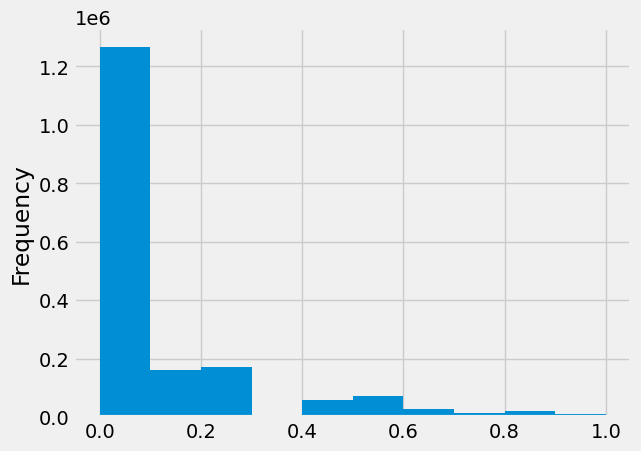

In [15]:
train_df.target.plot.hist()

Since for evaluation, the test set examples with target >= 0.5 will be considered to be in the positive class (toxic). The same notion will be applied here; The target from the train set will be transformed as bescribed above.

In [16]:
train_df.target = np.where(train_df.target> 0.5, 1, 0)
print(train_df.target.value_counts())


target
0    1698436
1     106438
Name: count, dtype: int64


In [17]:
train_df['target']

,target
id,
59848,0
59849,0
59852,0
59855,0
59856,1
...,...
6333967,0
6333969,0
6333982,0


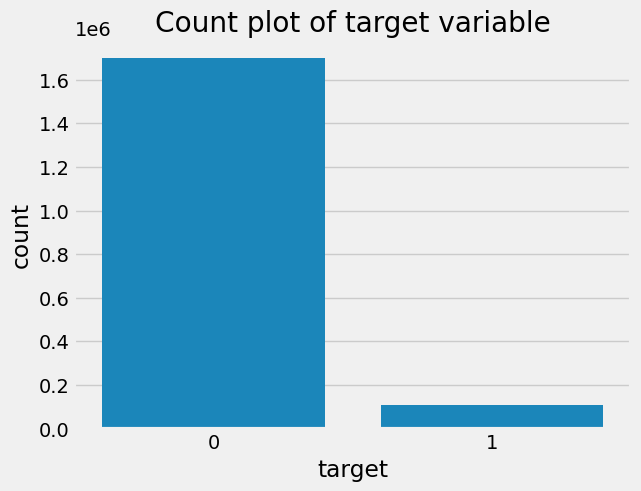

In [18]:
sns.countplot(x='target', data=train_df)
plt.title('Count plot of target variable')
plt.show()

Converting the character feature 'rating' which takes 2 values;approved and rejected to a binary feature.   

In [19]:
train_df['rating']=np.where(train_df['rating']=='approved',1,0)
train_df['rating'].value_counts()

,count
rating,
1,1684758
0,120116


<Axes: xlabel='rating', ylabel='count'>

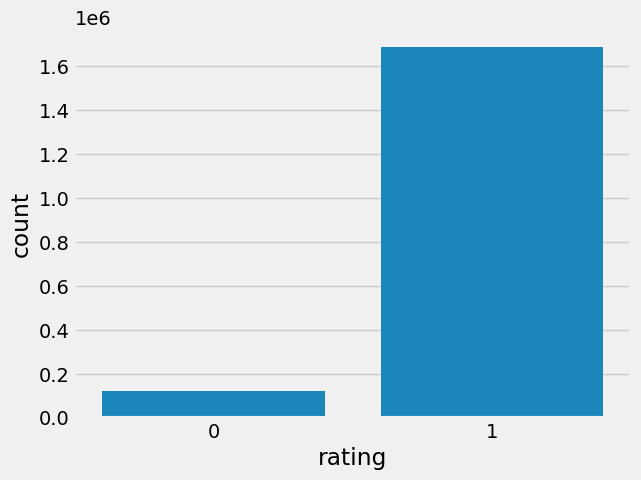

In [20]:
sns.countplot(x=train_df['rating'])

In [21]:
train_df.columns

Index(['target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [22]:
len(train_df.columns)

44

In [23]:
train_df.dtypes

,0
target,int64
comment_text,object
severe_toxicity,float64
obscene,float64
identity_attack,float64
insult,float64
threat,float64
asian,float64
atheist,float64
bisexual,float64


In [24]:
features = ['severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count']


toxicity_features = ["severe_toxicity", "obscene", "threat", "insult", "identity_attack", "sexual_explicit"]

identity_features = ["male", "female", "transgender", "other_gender", "heterosexual", "homosexual_gay_or_lesbian",
                     "bisexual", "other_sexual_orientation", "christian", "jewish", "muslim", "hindu", "buddhist",
                     "atheist", "other_religion", "black", "white", "asian", "latino", "other_race_or_ethnicity",
                     "physical_disability", "intellectual_or_learning_disability", "psychiatric_or_mental_illness", "other_disability"]

metadata_features = ["rating", "funny", "wow", "sad", "likes", "disagree", "toxicity_annotator_count", "identity_annotator_count"]

In [25]:
train_df[features].head()

,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,...,white,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0.0,0,4
59849,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0.0,0,4
59852,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0.0,0,4
59855,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,0,0,0,0,0.0,0,4
59856,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,1,0,0.0,4,47


distribution columns


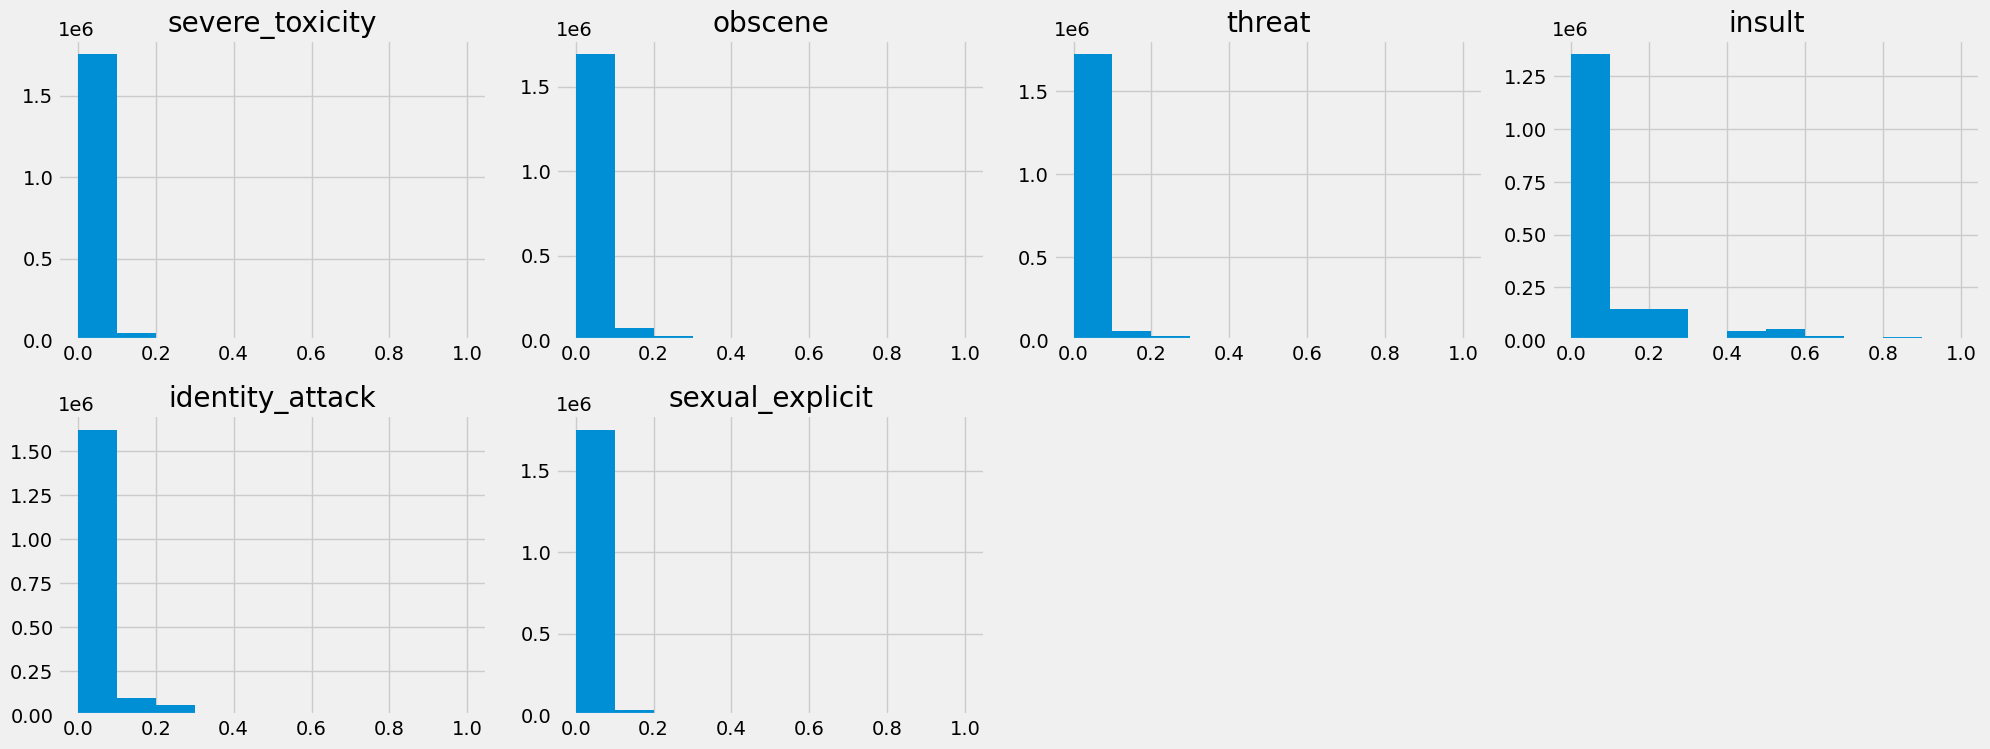

In [26]:
print('distribution columns')
plt.figure(figsize=(20,150))
for i, col in enumerate(toxicity_features):
    plt.subplot(40,4,i+1)
    plt.hist(train_df[col])
    plt.title(col)
plt.tight_layout()

distribution columns


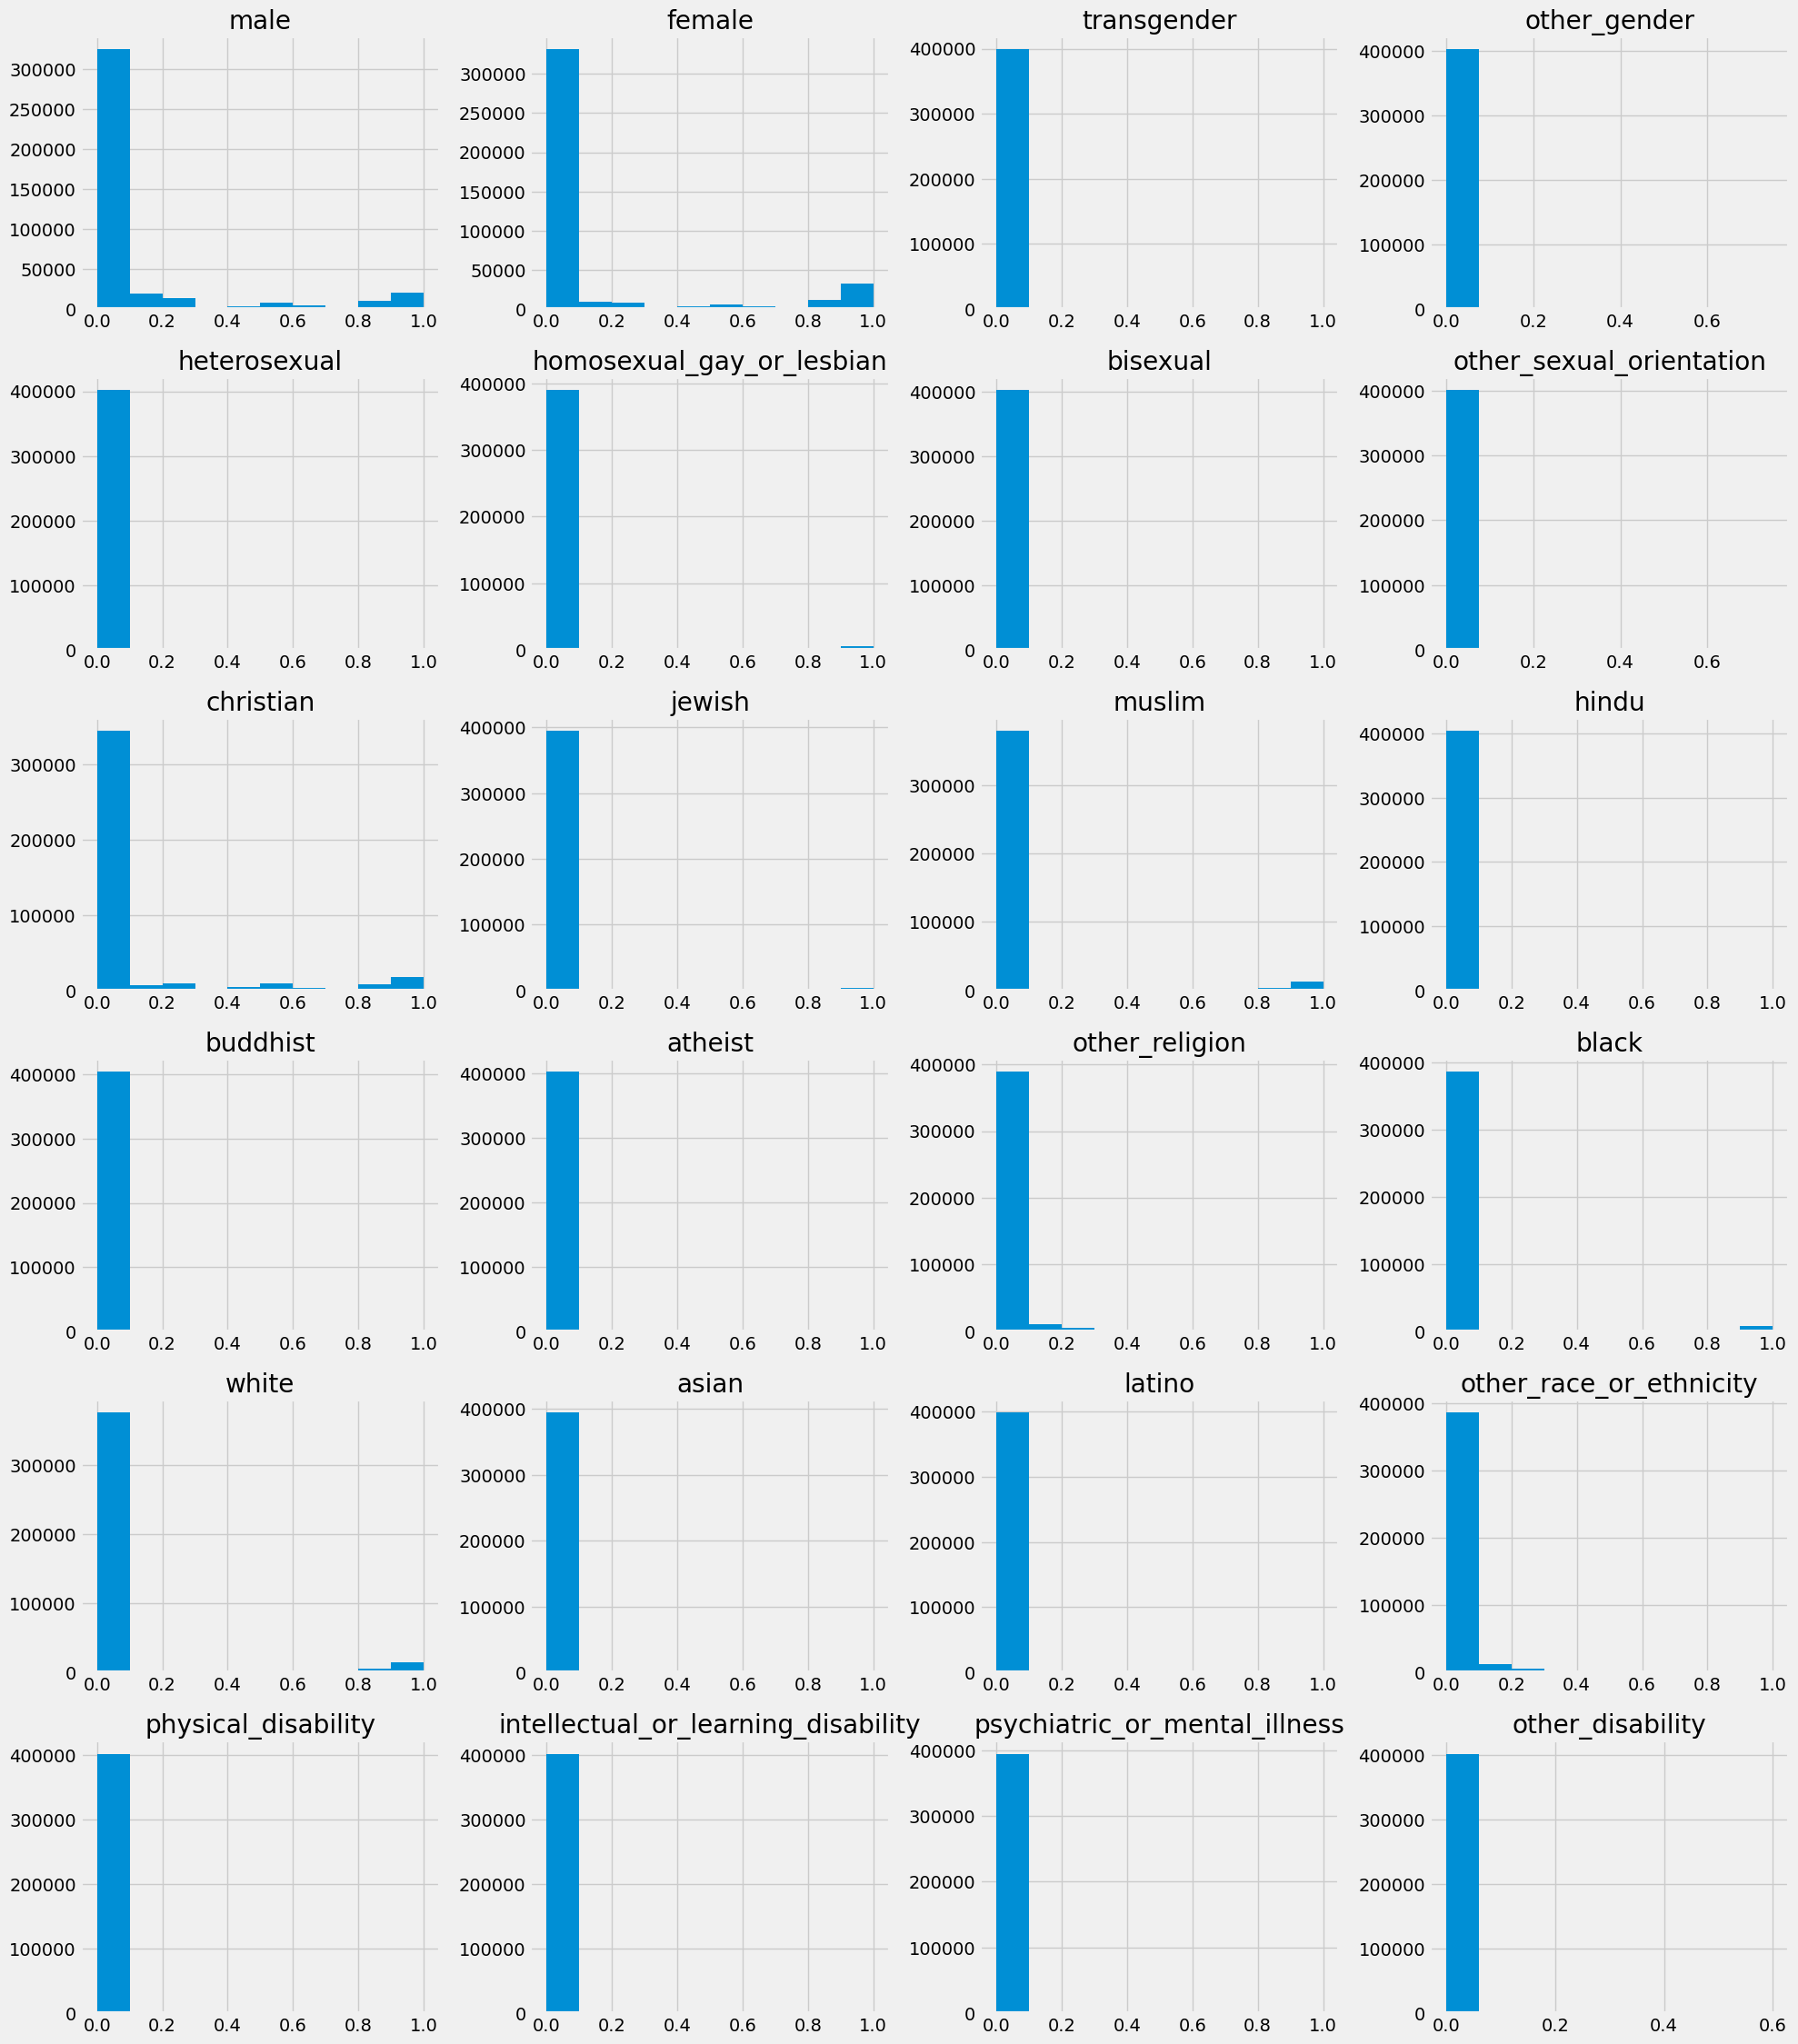

In [27]:
print('distribution columns')
plt.figure(figsize=(20,150))
for i, col in enumerate(identity_features):
    plt.subplot(40,4,i+1)
    plt.hist(train_df[col])
    plt.title(col)
plt.tight_layout()

Distributions columns


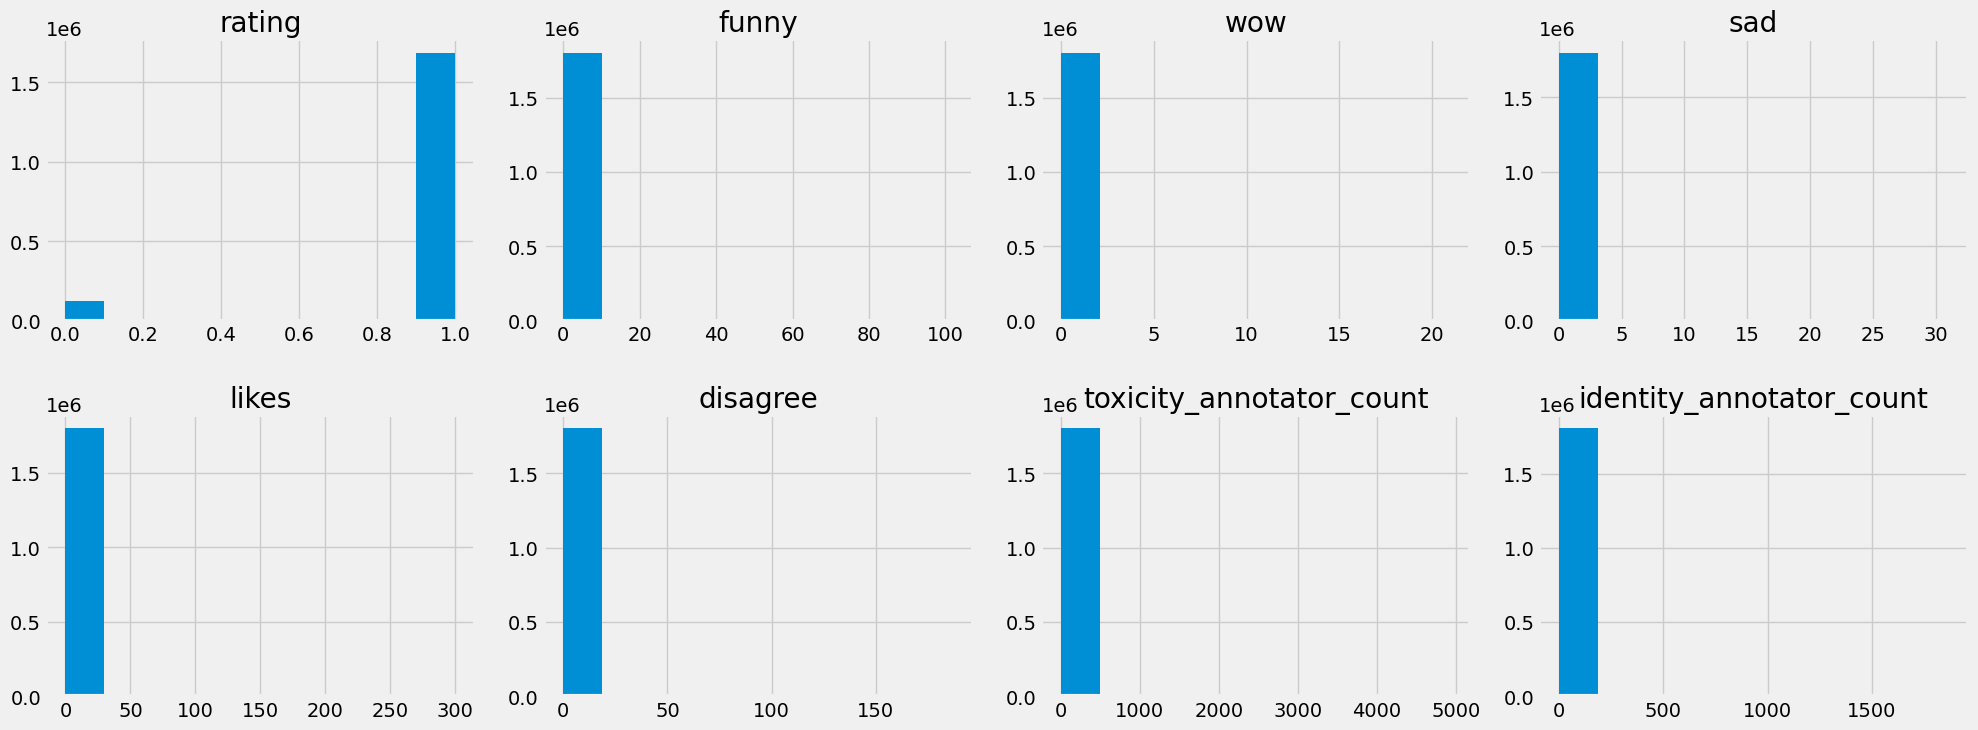

In [28]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(metadata_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col])
    plt.title(col)
plt.tight_layout()

Distributions columns


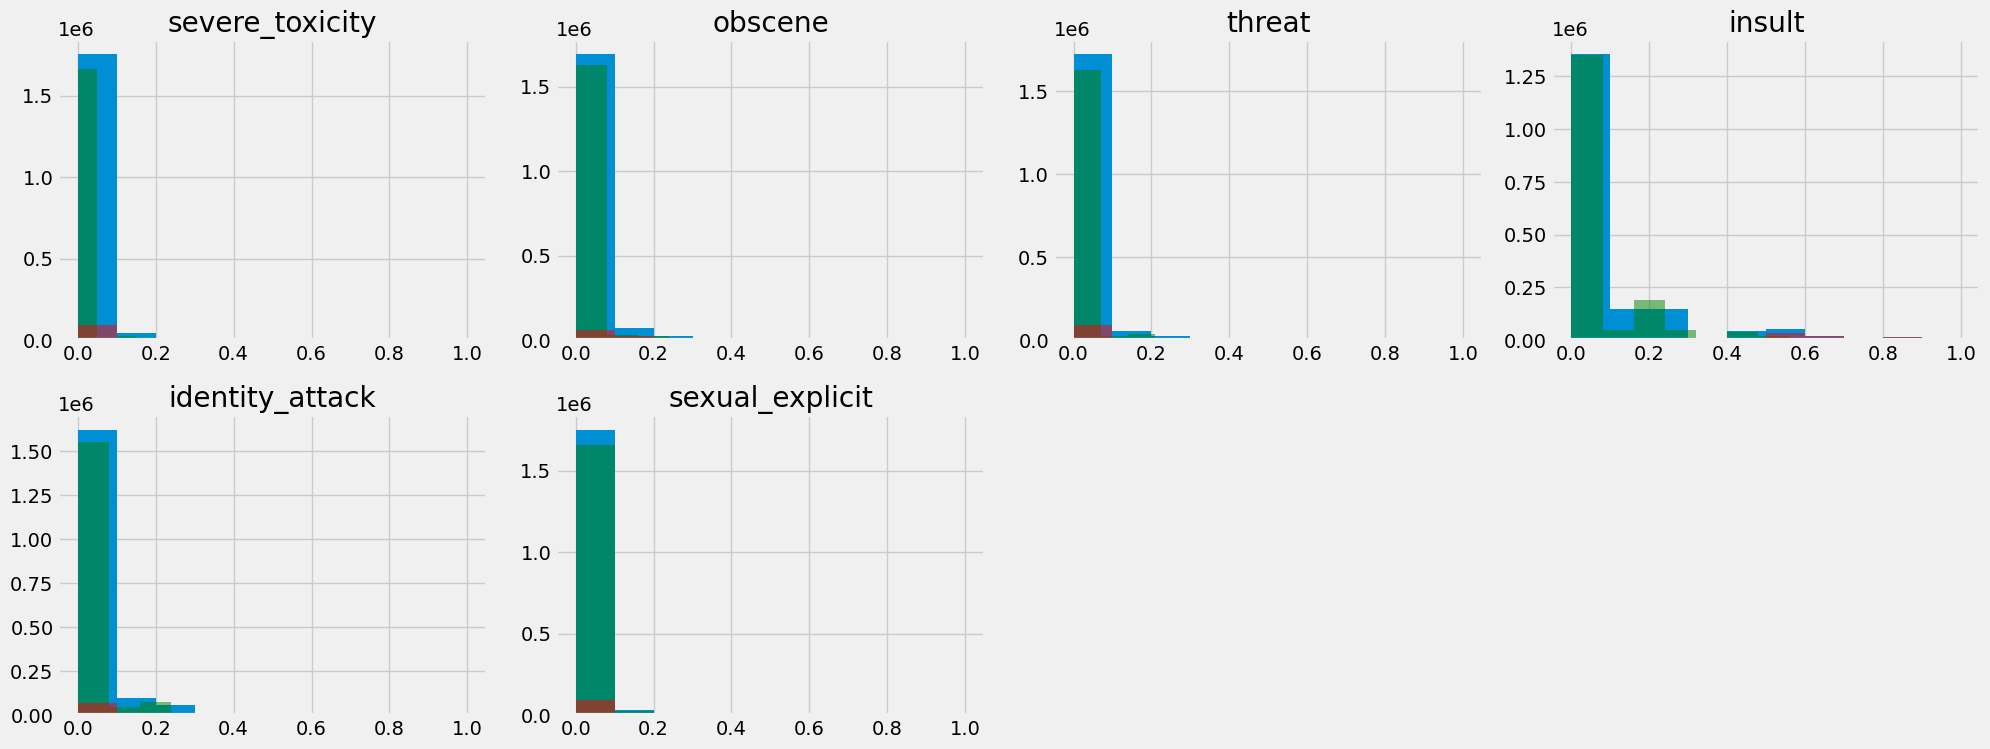

In [29]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(toxicity_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col])
    plt.hist(train_df[train_df["target"] == 0][col], alpha=0.5, label='0', color='g')
    plt.hist(train_df[train_df["target"] == 1][col], alpha=0.5, label='1', color='r')
    plt.title(col)
plt.tight_layout()

Distributions columns


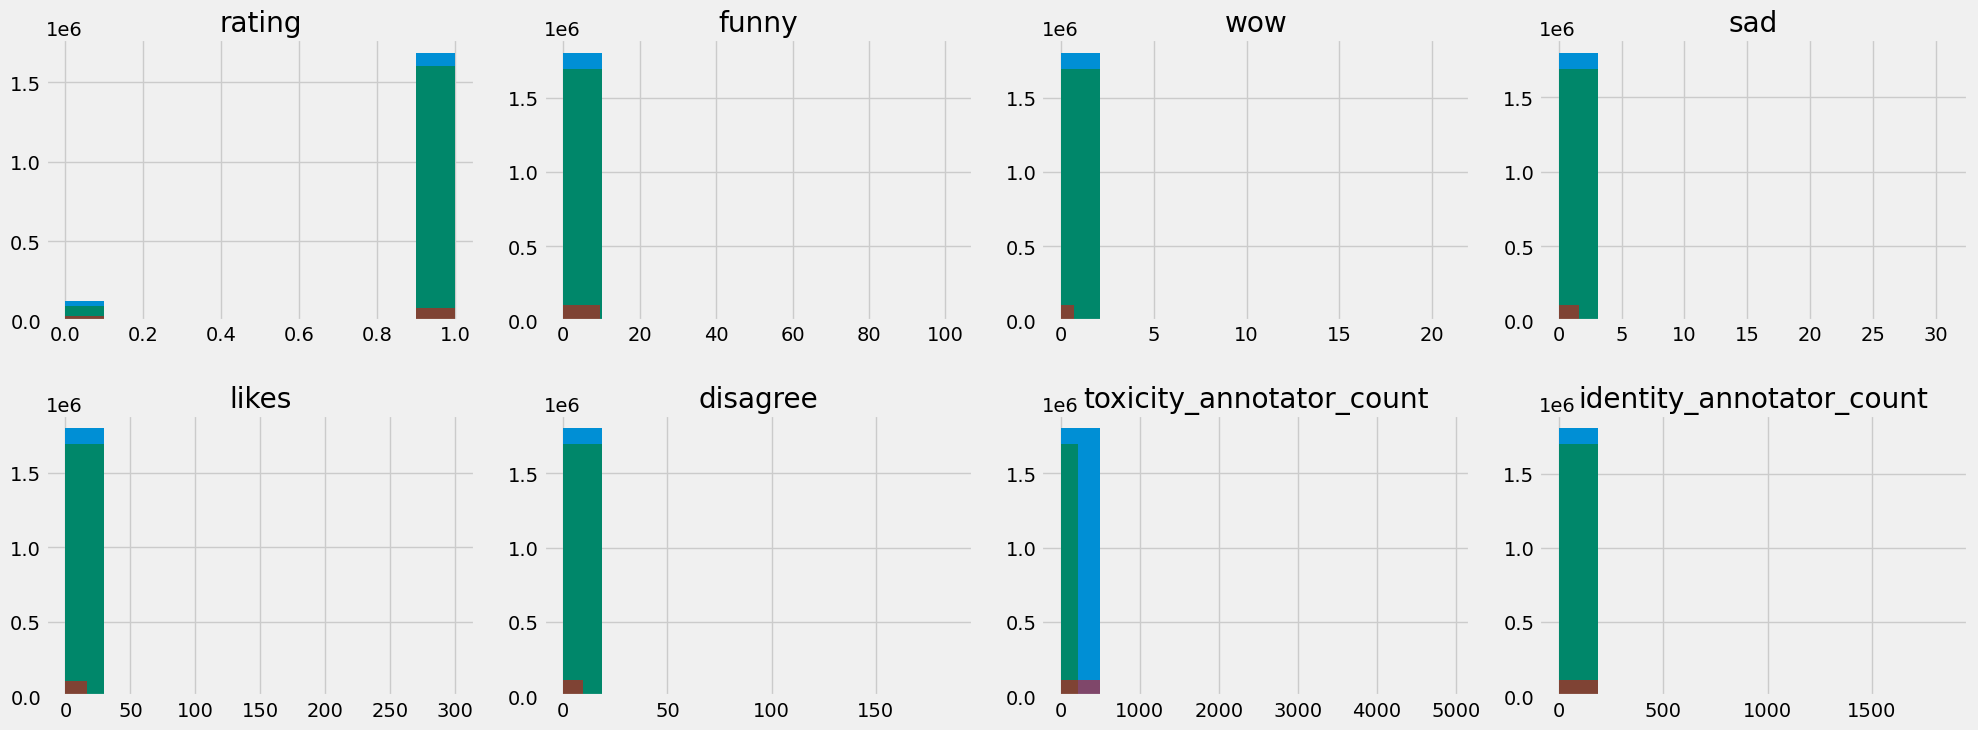

In [30]:
print('Distributions columns')
plt.figure(figsize=(20, 150))
for i, col in enumerate(metadata_features):
    plt.subplot(40, 4, i + 1)
    plt.hist(train_df[col])
    plt.hist(train_df[train_df["target"] == 0][col], alpha=0.5, label='0', color='g')
    plt.hist(train_df[train_df["target"] == 1][col], alpha=0.5, label='1', color='r')
    plt.title(col)
plt.tight_layout()

In [31]:
plt.close();
gc.collect();

In [32]:
train_data = train_df["comment_text"]
label_data = train_df["target"]
test_data = test_df["comment_text"]
train_data.shape, label_data.shape, test_data.shape

((1804874,), (1804874,), (97320,))

## tokneization, padding,embedding, model

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_data) + list(test_data))

In [34]:
train_data=tokenizer.texts_to_sequences(train_df['comment_text'])
test_data=tokenizer.texts_to_sequences(test_df['comment_text'])

In [35]:
Max_Len=200
train_data=sequence.pad_sequences(train_data,maxlen=Max_Len)
test_data=sequence.pad_sequences(test_data,maxlen=Max_Len)

xtrain,xvalid,ytrain,yvalid=train_test_split(train_data,label_data,stratify=train_df.target,random_state=42,test_size=.2,shuffle=True)

In [36]:
max_features=len(tokenizer.word_index)+1
max_features

409328

In [37]:
embedding_path1 = "input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"
# embedding_path2 = "input/glove840b300dtxt/glove.840B.300d.txt"
embed_size = 300

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def build_matrix(embedding_path, tokenizer):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = build_matrix(embedding_path1, tokenizer)

In [38]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
NUM_HIDDEN = 256
EMB_SIZE = 300
LABEL_SIZE = 1
MAX_FEATURES = max_features
DROP_OUT_RATE = 0.2
DENSE_ACTIVATION = "sigmoid"
NUM_EPOCH = 5
conv_size = 128

BATCH_SIZE = 512
LOSS_FUNC = "binary_crossentropy"
OPTIMIZER_FUNC = "adam"
METRICS = ["accuracy"]

from numpy.random import seed
seed(42)


model=Sequential()
model.add(Embedding(max_features, EMB_SIZE, weights=[embedding_matrix], trainable=False))
#model.add(keras.layers.Embedding(max_features, EMB_SIZE))
model.add(SpatialDropout1D(DROP_OUT_RATE))
model.add(LSTM(NUM_HIDDEN, return_sequences=True))
#model.add(Dropout(rate=DROP_OUT_RATE))
model.add(Conv1D(conv_size, 2, activation='relu', padding='same'))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(conv_size, 3, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
#model.add(Flatten())
model.add(Dense(LABEL_SIZE, activation=DENSE_ACTIVATION))

checkpointer = ModelCheckpoint(monitor='val_acc', mode='max', filepath='model.keras', verbose=2, save_best_only=True)
earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=0, mode='max')

model.compile(loss=LOSS_FUNC, optimizer=OPTIMIZER_FUNC, metrics=METRICS)

history_lstm = model.fit(
    xtrain,
    ytrain,
    batch_size = BATCH_SIZE,
    epochs = NUM_EPOCH, callbacks=[checkpointer, earlyStopping],
validation_data=(xvalid, yvalid))

Epoch 1/5
 115/2821 ━━━━━━━━━━━━━━━━━━━━ 6:29:47 9s/step - accuracy: 0.9400 - loss: 0.2540

In [ ]:
plot_history(history_lstm)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred_lstm = model.predict_classes(xvalid, verbose=1, batch_size = BATCH_SIZE)
print(classification_report(yvalid, y_pred_lstm))

print()
print("accuracy_score", accuracy_score(yvalid, y_pred_lstm))

print()
print("Weighted Averaged validation metrics")
print("precision_score", precision_score(yvalid, y_pred_lstm, average='weighted'))
print("recall_score", recall_score(yvalid, y_pred_lstm, average='weighted'))
print("f1_score", f1_score(yvalid, y_pred_lstm, average='weighted'))

print()
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(yvalid, y_pred_lstm)

In [ ]:
submission_in = 'input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv'
result = model.predict(test_data, verbose=1, batch_size = BATCH_SIZE)

submission = pd.read_csv(submission_in, index_col='id')
submission['prediction'] = result
submission.reset_index(drop=False, inplace=True)
submission.to_csv('submission.csv',index=False)